# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


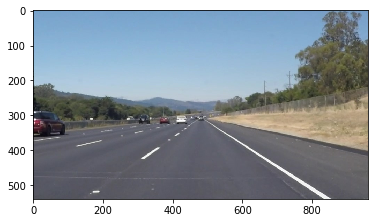

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1,y1),(x2,y2), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    assert img.shape==initial_img.shape
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [4]:
def draw_extra_lines(img, lines, color=[255, 0, 0], thickness=2,verbose=False):
    """
    Extrapolate the lines
    """
    x_left=[]
    y_left=[]
    x_right=[]
    y_right=[]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            m=((y2-y1)/(x2-x1)) 
            if m>0:
                x_left.append(x2)
                x_left.append(x1)
                y_left.append(y2)
                y_left.append(y1)
                #cv2.line(img, (x1,y1),(x2,y2), color, thickness)
            elif m<0:
                x_right.append(x2)
                x_right.append(x1)
                y_right.append(y2)
                y_right.append(y1)
                #cv2.line(img, (x1,y1),(x2,y2), [0,255,0], thickness)
    
    p1=np.polyfit(y_left,x_left,deg=1)
    p2=np.polyfit(y_right,x_right,deg=1)
    
    if verbose==True:
        print("m1=%s"%p1[0])
        print("m2=%s"%p2[0])
    
    x_left_start=0*p1[0]+p1[1]
    x_left_end=p1[0]*img.shape[0]+p1[1]
    
    x_right_start=0*p1[0]+p2[1]
    x_right_end=p2[0]*img.shape[0]+p2[1]
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    cv2.line(line_img, (int(x_left_start), 0), (int(x_left_end), img.shape[0]), color, thickness)
    cv2.line(line_img, (int(x_right_start), 0), (int(x_right_end), img.shape[0]), color, thickness)
    return line_img

In [5]:
def draw_extra_lines_2(img, lines, color=[255, 0, 0], thickness=2,verbose=False):
    """
    Extrapolate the lines
    """
    x_left=[]
    y_left=[]
    x_right=[]
    y_right=[]
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            m=((y2-y1)/(x2-x1)) 
            if m>0.3:
                x_left.append(x2)
                x_left.append(x1)
                y_left.append(y2)
                y_left.append(y1)
                #cv2.line(img, (x1,y1),(x2,y2), color, thickness)
            elif m<-0.3:
                x_right.append(x2)
                x_right.append(x1)
                y_right.append(y2)
                y_right.append(y1)
                #cv2.line(img, (x1,y1),(x2,y2), [0,255,0], thickness)
    
    if len(y_left)<2 or len(y_right)<2:
        return line_img
    p1=np.polyfit(y_left,x_left,deg=1)
    p2=np.polyfit(y_right,x_right,deg=1)
    
    if verbose==True:
        print("m1=%s"%p1[0])
        print("m2=%s"%p2[0])
    
    x_left_start=0*p1[0]+p1[1]
    x_left_end=p1[0]*img.shape[0]+p1[1]
    
    x_right_start=0*p1[0]+p2[1]
    x_right_end=p2[0]*img.shape[0]+p2[1]
    
   
    cv2.line(line_img, (int(x_left_start), 0), (int(x_left_end), img.shape[0]), color, thickness)
    cv2.line(line_img, (int(x_right_start), 0), (int(x_right_end), img.shape[0]), color, thickness)
    return line_img

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
file_list=os.listdir("test_images/")

run your solution on all test_images and make copies into the test_images directory).

### Show all images

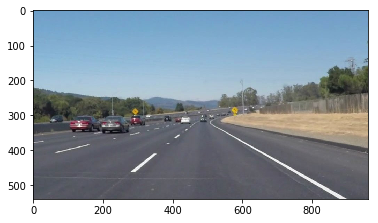

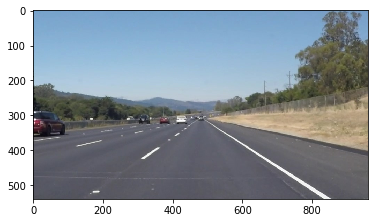

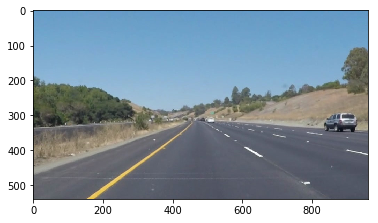

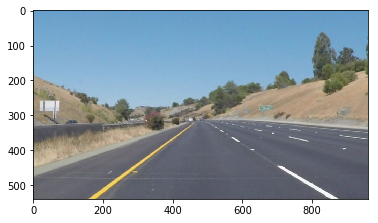

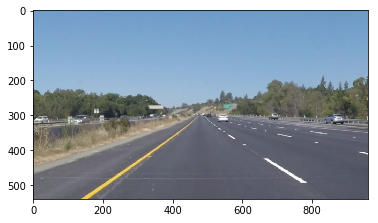

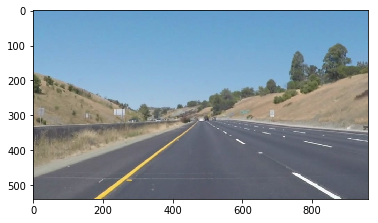

In [7]:
for file in file_list:
    show_image=mpimg.imread("./test_images/"+file)
    plt.figure()
    plt.imshow(show_image)

## Lane detection

### Use the helper function and the content in the course to identify the lanes

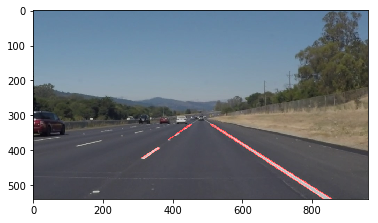

In [8]:
#image=mpimg.imread("./test_images/solidYellowCurve.jpg")
gray_image=grayscale(image)
gb_image=gaussian_blur(gray_image,5)
can_image=canny(gb_image, 50, 150)
hu_image=hough_lines(can_image, 2, math.pi/180, threshold=15, min_line_len=40, max_line_gap=20)
hu_image=region_of_interest(hu_image, [np.array([[120,539],[900,539],[550,325],[450,325]],dtype='int32')])
weighted_image=weighted_img(hu_image, image, α=0.8, β=1., λ=0.)
plt.imshow(weighted_image)

### Extrapolate the lines

Identify the line

(540, 960)


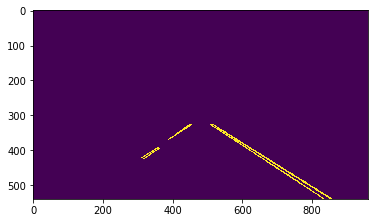

In [9]:
gray_hu_image=grayscale(hu_image)
lines = cv2.HoughLinesP(gray_hu_image, 2, math.pi/180, 15, np.array([]), 
                        minLineLength=40, maxLineGap=20)
plt.imshow(gray_hu_image)
print(gray_hu_image.shape)

Do extrapolation

m1=1.57149057729
m2=-1.38566513811


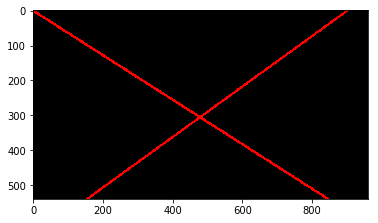

In [10]:
line_image=draw_extra_lines(gray_hu_image,lines,thickness=5,verbose=True)
plt.imshow(line_image)

Use ```region_of_interest()``` to select the region.

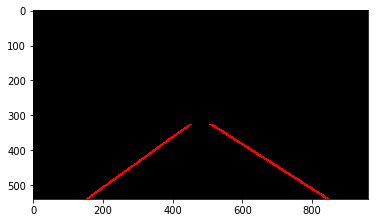

In [11]:
cutted_gray_hu_image=region_of_interest(line_image, 
                                        [np.array([[120,539],[900,539],[550,325],[450,325]],
                                                  dtype='int32')])
plt.imshow(cutted_gray_hu_image)

Draw the lines on the original images.

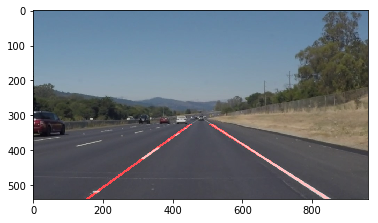

In [12]:
exp_weighted_image=weighted_img(cutted_gray_hu_image, image, α=0.8, β=1., λ=0.)
plt.imshow(exp_weighted_image)

In [13]:
# Wrap the above procedures into one function
def detect_lane(image):
    image_x=image.shape[1]
    image_y=image.shape[0]
    p1=[int(120/960*image_x),image_y-1]
    p2=[int(900/960*image_x),image_y-1]
    p3=[int(550/960*image_x),int(325/540*image_y)]
    p4=[int(450/960*image_x),int(325/540*image_y)]
    
    gray_image=grayscale(image)
    gb_image=gaussian_blur(gray_image,5)
    can_image=canny(gb_image, 50, 150)
    hu_image=hough_lines(can_image, 2, 
                         math.pi/180, threshold=15, min_line_len=40, max_line_gap=20)
    hu_image=region_of_interest(hu_image, 
                                #[np.array([[120,539],[900,539],[550,325],[450,325]],dtype='int32')])
                                [np.array([p1,p2,p3,p4],dtype='int32')])
    gray_hu_image=grayscale(hu_image)
    lines = cv2.HoughLinesP(gray_hu_image, 2, math.pi/180, 15, np.array([]), 
                        minLineLength=40, maxLineGap=20)
    line_image=draw_extra_lines_2(gray_hu_image,lines,thickness=5)
    cutted_gray_hu_image=region_of_interest(line_image, 
                                        [np.array([p1,p2,p3,p4],dtype='int32')])
    exp_weighted_image=weighted_img(cutted_gray_hu_image, image, α=0.8, β=1., λ=0.)
    return exp_weighted_image

## Perform lane detection on all test images

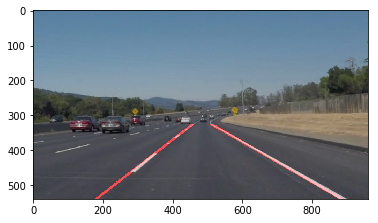

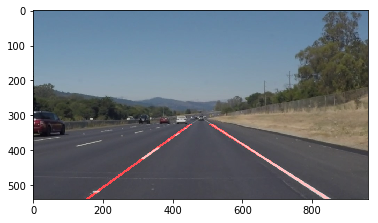

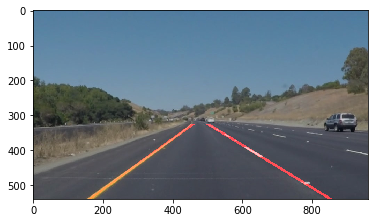

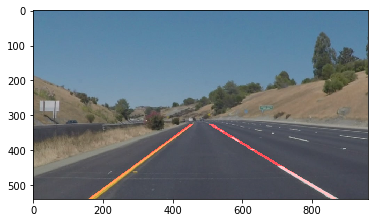

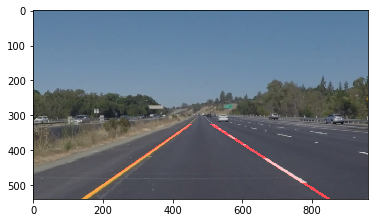

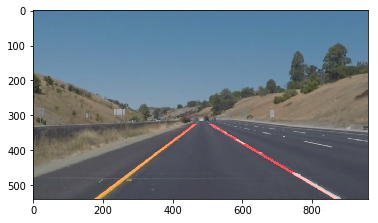

In [14]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
for file in file_list:
    show_image=mpimg.imread("./test_images/"+file)
    result_image=detect_lane(show_image)
    plt.figure()
    plt.imshow(result_image)
    mpimg.imsave("./test_images/"+file[0:-4]+".jpg",result_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result=detect_lane(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [17]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:09<00:00, 23.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 10.3 s, sys: 940 ms, total: 11.2 s
Wall time: 10.4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [19]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:27<00:00, 24.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 31 s, sys: 1.66 s, total: 32.7 s
Wall time: 28.3 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

My land finding pipeline follows the procedures introduced in the course materials, namely,
1. Use Canny edge detection to locate the edges.
2. Use Hough transformation to find the lines in the photo.
3. Select the region of interest to drop the lines that are not relevant.
4. Extrapolate and average the detected lanes.

My implmentation of step 4 is:
1. Find the slopes all the line segments.
2. Based on the slopes, classify the end points of these line segments into left lane or right lane.
3. Run linear regression of all the collected points in the two lanes, respectively.
4. Redraw the lanes using the fitted slope and intercepts.

The current algorithm is likely to fail in the following ways:
1. The region of interest may change if the camera is misaligned or the width of the road changes.
2. The current extrapolation algorithms only works when the region of interest only has lanes. It becomes less accurate if other objects show up in this region, such as cars, shadows or other road signs.

I made the following changes to generalize this algorithm a little bit to address the Optional Challenge in the next section:
1. Use ratio instead of fixed coordinates to assign the region of interest. In this way, this algorithm can at least deal with the images with different resolution.
2. When doing extrapolation, only average the line segments that has the slope larger than 0.3 or less than -0.3. This helps reduce the noise caused by other object in the region of interest.

However, these modification still not be able to cope with situations such shadows. Even human sometimes cannot identify the lane correctly in these situations. However, human can uses the lane he saw previously to help resolve the lane in these situations. This method can be implemented in the lane detection algorithm. For example, we could use the lane we found in previous frame as a prior, and use this prior to better determine the slopes of the next frame.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [21]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:19<00:00, 16.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 19.9 s, sys: 450 ms, total: 20.4 s
Wall time: 21 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))